# Классификация 128x128 + U-Net c бэкбоном

## Датасеты

### Классификация: Tiny ImageNet-200 из семинара 2.
Набор данных необходимо взять из второго семинара и привести к разрешению 128x128  
Разрешение: приведите вход к 128×128 (ресайз/кроп по вашему выбору, главное — корректно описать в отчёте).

берём `TinyImageNetDataset` из прошлой домашки

In [1]:
import sys
from pathlib import Path

ROOT_DIR = Path.cwd().parent
sys.path.insert(0, str(ROOT_DIR))

from hw_2.TinyImageNetDataset import TinyImageNetDataset

### Сегментация: MOON_SEGMENTATION_BINARY из семинара 3.
Структура: images/render/*.png — входы, images/ground/*.png — бинарные маски.


Реализация [тут](./MoonSegmentationDataset.py)

In [2]:
from hw_3.MoonSegmentationDataset import MoonSegmentationDataset

## Часть 1. Классификатор 128×128

* Требования к модели:
    * Своя архитектура (разрешается вдохновляться CNN-идеями: Conv-BN-ReLU, блоки с даунсемплингом, GAP и т.д.).
    * Ограничение на параметризованность: не более ~5M параметров.
    * Вход: 128×128×3.
    * Можно выбрать любое количество классов для обучения!
* Обучение:
    * Трен/вал сплит: выберите собственную стратификацию.
    * Аугментации: разумные (кроп, флипы, color jitter и т.д.), кратко опишите в отчёте.
* Что сдаём по части 1:
    * График/лог обучения (loss/accuracy по эпохам) и итоговые метрики на валидации.
    * Чекпоинт модели (по возможности) или веса/ссылка.


In [3]:
from hw_2.ResNet18 import ResNet18

In [4]:
res_net_model = ResNet18(
    num_classes=10,
    # num_classes=20,
    use_layer4=False,
    channels=[64, 128, 256, 512]
)


Делаем меньше 5млн параметров

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(res_net_model):,}")

Total parameters: 2,777,674


Аугментации для трейна:
* случайный кроп
* горизонтальный флип
* цветовые искажения.
  
В валидации соответсвенно без аугментаций, только resize и нормализация

In [6]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.RandomCrop((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Разбиваем на train/val в пропорции 80/20 со стратификацией по классам.

In [8]:
classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900',
            'n01698640', 'n01742172', 'n01768244', 'n01770393',
            'n01774384', 'n01774750',
            # 'n01855672', 'n01882714', 'n01910747', 'n01917289',
            # 'n01930112', 'n01943899', 'n01944390', 'n01945685',
            # 'n01950731', 'n01955084'
          ]

# classes = ["n12267677", "n09428293"]

train_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    transform=train_transform,
    selected_classes=classes
)

val_dataset = TinyImageNetDataset(
    root_dir="../hw_2/tiny-imagenet-200",
    transform=val_transform,
    selected_classes=classes
)


In [9]:
train_dataset[1][1]

2

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(train_dataset)))
labels = [train_dataset[i][1] for i in indices]

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)


Делаем даталоадеры

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)



In [12]:
x, y = train_dataset[0]
print(x.shape)      # torch.Size([3, 128, 128])
print(x.min(), x.max())  # примерно [-2.1, 2.6]


torch.Size([3, 128, 128])
tensor(-2.1179) tensor(1.3256)


[train](../hw_2/train.py) снова берём из прошлой домашки

In [13]:
from hw_2.train import train

In [14]:
res_net_train_losses, res_net_val_losses, res_net_train_accs, res_net_val_accs = train(res_net_model, train_loader, val_loader, num_epochs = 25)

Epoch [1/25] | Train Loss: 2.0534, Train Acc: 0.2679 | Val Loss: 1.9666, Val Acc: 0.2857
Epoch [2/25] | Train Loss: 1.9220, Train Acc: 0.3194 | Val Loss: 1.9484, Val Acc: 0.3096
Epoch [3/25] | Train Loss: 1.8373, Train Acc: 0.3519 | Val Loss: 2.9510, Val Acc: 0.2689
Epoch [4/25] | Train Loss: 1.7581, Train Acc: 0.3872 | Val Loss: 1.9999, Val Acc: 0.3541
Epoch [5/25] | Train Loss: 1.7391, Train Acc: 0.3881 | Val Loss: 1.9253, Val Acc: 0.3254
Epoch [6/25] | Train Loss: 1.6623, Train Acc: 0.4189 | Val Loss: 1.7886, Val Acc: 0.3566
Epoch [7/25] | Train Loss: 1.6317, Train Acc: 0.4281 | Val Loss: 1.7719, Val Acc: 0.4068
Epoch [8/25] | Train Loss: 1.5939, Train Acc: 0.4442 | Val Loss: 1.8058, Val Acc: 0.3891
Epoch [9/25] | Train Loss: 1.5626, Train Acc: 0.4616 | Val Loss: 1.7073, Val Acc: 0.4227
Epoch [10/25] | Train Loss: 1.5054, Train Acc: 0.4740 | Val Loss: 1.7489, Val Acc: 0.4430
Epoch [11/25] | Train Loss: 1.4945, Train Acc: 0.4990 | Val Loss: 2.0276, Val Acc: 0.4059
Epoch [12/25] | Tra

строим графики

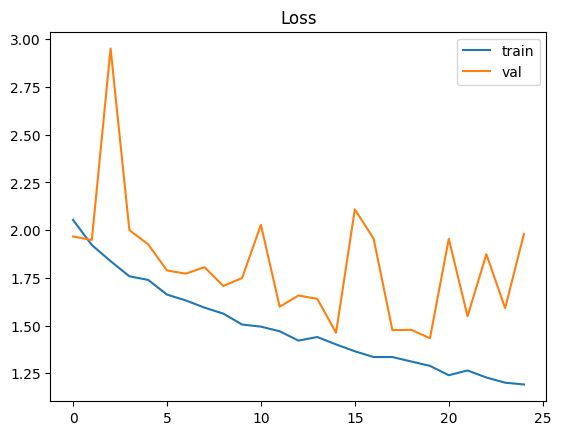

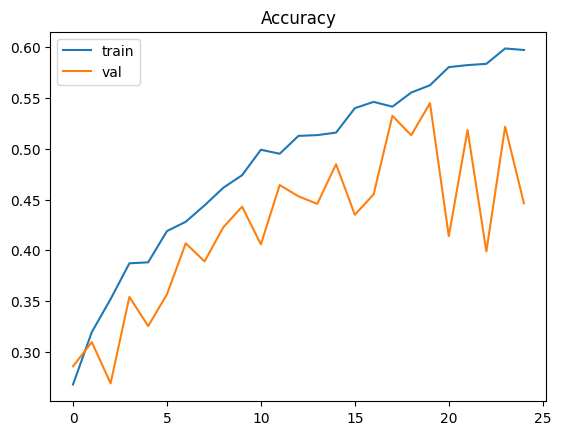

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(res_net_train_losses, label="train")
plt.plot(res_net_val_losses, label="val")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(res_net_train_accs, label="train")
plt.plot(res_net_val_accs, label="val")
plt.title("Accuracy")
plt.legend()
plt.show()


и сохраняемся

In [16]:
import torch
torch.save(res_net_model.state_dict(), "resnet18_weights.pth")

## Часть 2. Базовая U-Net на "Луне"

* Требования к архитектуре U-Net (зафиксируйте и опишите в отчёте):
    * Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
    * Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).
    * Даунсемплинг: stride 2 или MaxPool.
    * Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
    * Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).
    * Вход: 128×128×3.
* Обучение:
    * Лосс: BCEWithLogitsLoss или Dice Loss, допустимо комбинировать (например, 0.5BCE + 0.5Dice).
    * Метрики для мониторинга: IoU (Jaccard), Dice, Pixel Accuracy.
    * Аугментации: горизонтальные/вертикальные флипы, лёгкие геометрические и цветовые — по желанию (можно добавлять другие).
* Что сдаём по части 2:
    * Логи обучения и итоговые метрики на валидации: IoU, Dice, Pixel Acc.
    * 3–5 визуализаций: вход, предсказанная маска, GT маска.


In [17]:
from hw_3.UNet import UNet
from hw_3.BasicBlock import ResNetEncoder

In [18]:
from torch import nn

class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

Для обучения использовались аугментации: случайный кроп, горизонтальные и вертикальные флипы, небольшие геометрические преобразования и цветовые искажения. Для валидации применялся только ресайз. Все изображения приводились к разрешению 128×128.

In [19]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_augmentation = A.Compose([
    A.Resize(144, 144),
    A.RandomCrop(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.5,
        border_mode=cv2.BORDER_REFLECT
    ),
    A.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1,
        p=0.5
    ),
])

/home/dr_drew/.python_venvs/main-env/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [20]:
val_augmentation = A.Compose([
    A.Resize(128, 128),
])

Препроцессинг общий для train и val

In [21]:
preprocessing = A.Compose([
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

In [22]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

moon_dataset_path = "./MOON_SEGMENTATION_BINARY"

images_dir = os.path.join(moon_dataset_path, "images", "render")
all_ids = sorted([
    img.replace(".png", "")
    for img in os.listdir(images_dir)
    if img.endswith(".png")
])

train_ids, val_ids = train_test_split(
    all_ids,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [23]:
moon_train_dataset = MoonSegmentationDataset(
    root_dir=moon_dataset_path,
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

moon_val_dataset = MoonSegmentationDataset(
    root_dir=moon_dataset_path,
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)


In [24]:
from torch.utils.data import DataLoader

moon_train_loader = DataLoader(
    moon_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

moon_val_loader = DataLoader(
    moon_val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


In [25]:
import torch
import cv2
from hw_3.insane_last_train import train

Создаём модель и запускаем обучение

In [26]:
model_unet = UNet(
    in_channels=3,
    out_channels=1,
    base_channels=32
).to("cuda")

criterion = CombinedLoss()

optimizer = torch.optim.AdamW(
    model_unet.parameters(), lr=3e-4
)

history_unet = train(
    model_unet,
    moon_train_loader,
    moon_val_loader,
    optimizer,
    criterion,
    device="cuda",
    epochs=30
)


Epoch 1/30 | Train IoU: 0.229, Val IoU: 0.259, Val Dice: 0.393, Val Pixel Acc: 0.879
Epoch 2/30 | Train IoU: 0.278, Val IoU: 0.300, Val Dice: 0.437, Val Pixel Acc: 0.911
Epoch 3/30 | Train IoU: 0.303, Val IoU: 0.305, Val Dice: 0.440, Val Pixel Acc: 0.914
Epoch 4/30 | Train IoU: 0.307, Val IoU: 0.278, Val Dice: 0.413, Val Pixel Acc: 0.916
Epoch 5/30 | Train IoU: 0.319, Val IoU: 0.305, Val Dice: 0.444, Val Pixel Acc: 0.902
Epoch 6/30 | Train IoU: 0.329, Val IoU: 0.307, Val Dice: 0.443, Val Pixel Acc: 0.907
Epoch 7/30 | Train IoU: 0.332, Val IoU: 0.305, Val Dice: 0.442, Val Pixel Acc: 0.916
Epoch 8/30 | Train IoU: 0.333, Val IoU: 0.320, Val Dice: 0.457, Val Pixel Acc: 0.922
Epoch 9/30 | Train IoU: 0.342, Val IoU: 0.329, Val Dice: 0.467, Val Pixel Acc: 0.913
Epoch 10/30 | Train IoU: 0.349, Val IoU: 0.324, Val Dice: 0.459, Val Pixel Acc: 0.929
Epoch 11/30 | Train IoU: 0.345, Val IoU: 0.336, Val Dice: 0.473, Val Pixel Acc: 0.928
Epoch 12/30 | Train IoU: 0.348, Val IoU: 0.324, Val Dice: 0.457

In [27]:
from hw_3.utils import plot_training_history

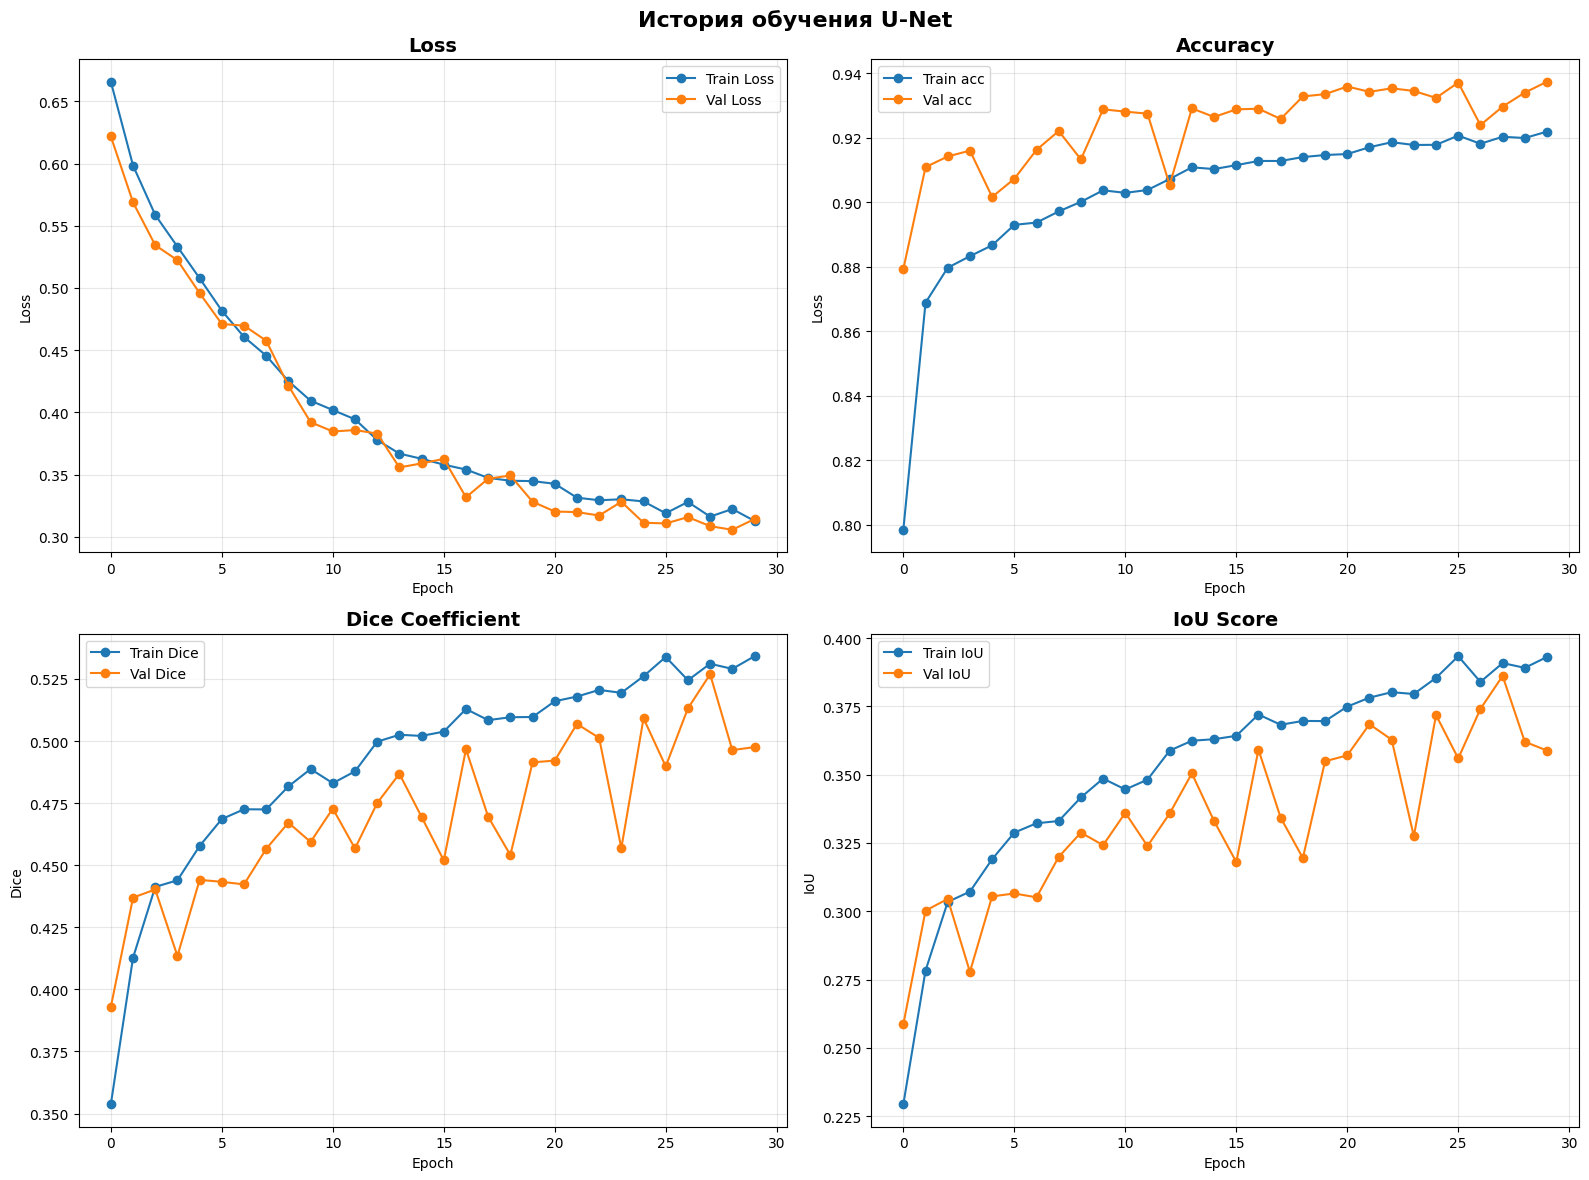

Train Loss: 0.3127
Val Loss: 0.3143
Train Dice: 0.5342
Val Dice: 0.4976
Train IoU: 0.3931
Val IoU: 0.3588
Val Accuracy: 0.9373


In [28]:
plot_training_history(history_unet)

Визуализации:

In [29]:
from hw_3.utils import visualize_predictions

In [30]:
moon_val_dataset[1][1].shape

torch.Size([128, 128])

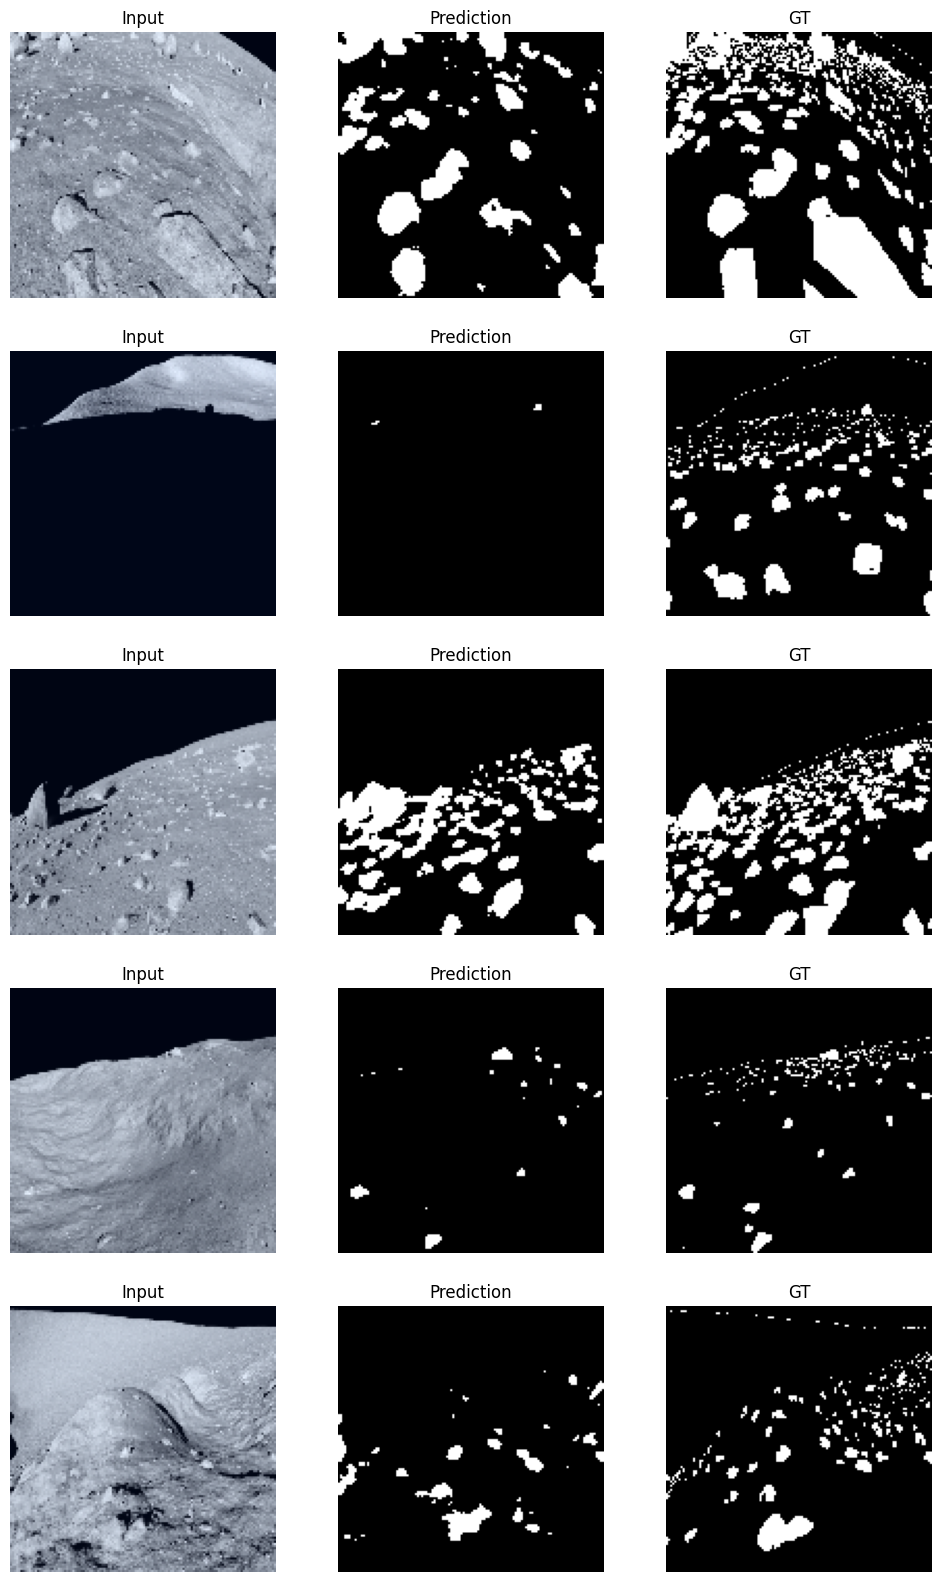

In [31]:
visualize_predictions(model_unet, moon_val_dataset, device="cuda", n=5)

## Часть 3. U-Net с бэкбоном из классификатора

`ResNetEncoder` - обёртка для resnet, описанного выше, чтобы его можно было использовать в `unet`

### Вариант A

Замораживаем энкодер, запускаем обучение

In [32]:
encoder = ResNetEncoder(res_net_model)

model_resunet = UNet(
    encoder=encoder,
    encoder_channels=[64, 64, 128, 256],
    freeze_encoder=True
).to("cuda")

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_resunet.parameters()),
    lr=3e-4
)
criterion = CombinedLoss()
history_resunet_frozen = train(
    model_resunet,
    moon_train_loader,
    moon_val_loader,
    optimizer,
    criterion,
    device="cuda",
    epochs=20
)


Epoch 1/20 | Train IoU: 0.266, Val IoU: 0.294, Val Dice: 0.431, Val Pixel Acc: 0.914
Epoch 2/20 | Train IoU: 0.299, Val IoU: 0.313, Val Dice: 0.453, Val Pixel Acc: 0.906
Epoch 3/20 | Train IoU: 0.308, Val IoU: 0.278, Val Dice: 0.412, Val Pixel Acc: 0.866
Epoch 4/20 | Train IoU: 0.315, Val IoU: 0.314, Val Dice: 0.453, Val Pixel Acc: 0.908
Epoch 5/20 | Train IoU: 0.314, Val IoU: 0.291, Val Dice: 0.428, Val Pixel Acc: 0.875
Epoch 6/20 | Train IoU: 0.312, Val IoU: 0.302, Val Dice: 0.439, Val Pixel Acc: 0.917
Epoch 7/20 | Train IoU: 0.322, Val IoU: 0.314, Val Dice: 0.452, Val Pixel Acc: 0.915
Epoch 8/20 | Train IoU: 0.320, Val IoU: 0.325, Val Dice: 0.465, Val Pixel Acc: 0.914
Epoch 9/20 | Train IoU: 0.328, Val IoU: 0.318, Val Dice: 0.457, Val Pixel Acc: 0.908
Epoch 10/20 | Train IoU: 0.327, Val IoU: 0.328, Val Dice: 0.466, Val Pixel Acc: 0.926
Epoch 11/20 | Train IoU: 0.330, Val IoU: 0.330, Val Dice: 0.468, Val Pixel Acc: 0.922
Epoch 12/20 | Train IoU: 0.332, Val IoU: 0.338, Val Dice: 0.479

In [33]:
history_resunet_frozen

{'train_loss': [0.580597887635231,
  0.5028337174654007,
  0.46574078261852264,
  0.4378752875328064,
  0.42563450694084165,
  0.41555038750171663,
  0.40297570049762726,
  0.3981808376312256,
  0.39094712436199186,
  0.39158249080181123,
  0.3832928341627121,
  0.37973764300346374,
  0.3749170762300491,
  0.3819336313009262,
  0.37358782947063446,
  0.3743646365404129,
  0.37445008456707,
  0.3700025945901871,
  0.3695594722032547,
  0.36380420982837675],
 'val_loss': [0.49791173815727235,
  0.46322539567947385,
  0.4958046054840088,
  0.41092670083045957,
  0.4484991145133972,
  0.3914415574073791,
  0.3798525583744049,
  0.37267070293426513,
  0.3749356722831726,
  0.35765339851379396,
  0.3551366901397705,
  0.3664371144771576,
  0.36060797452926635,
  0.3528933167457581,
  0.3541571116447449,
  0.34643608450889585,
  0.34354021787643435,
  0.34770470261573794,
  0.3437325382232666,
  0.3399669063091278],
 'train_iou': [0.26560840278863906,
  0.29945758074522016,
  0.30830581218004

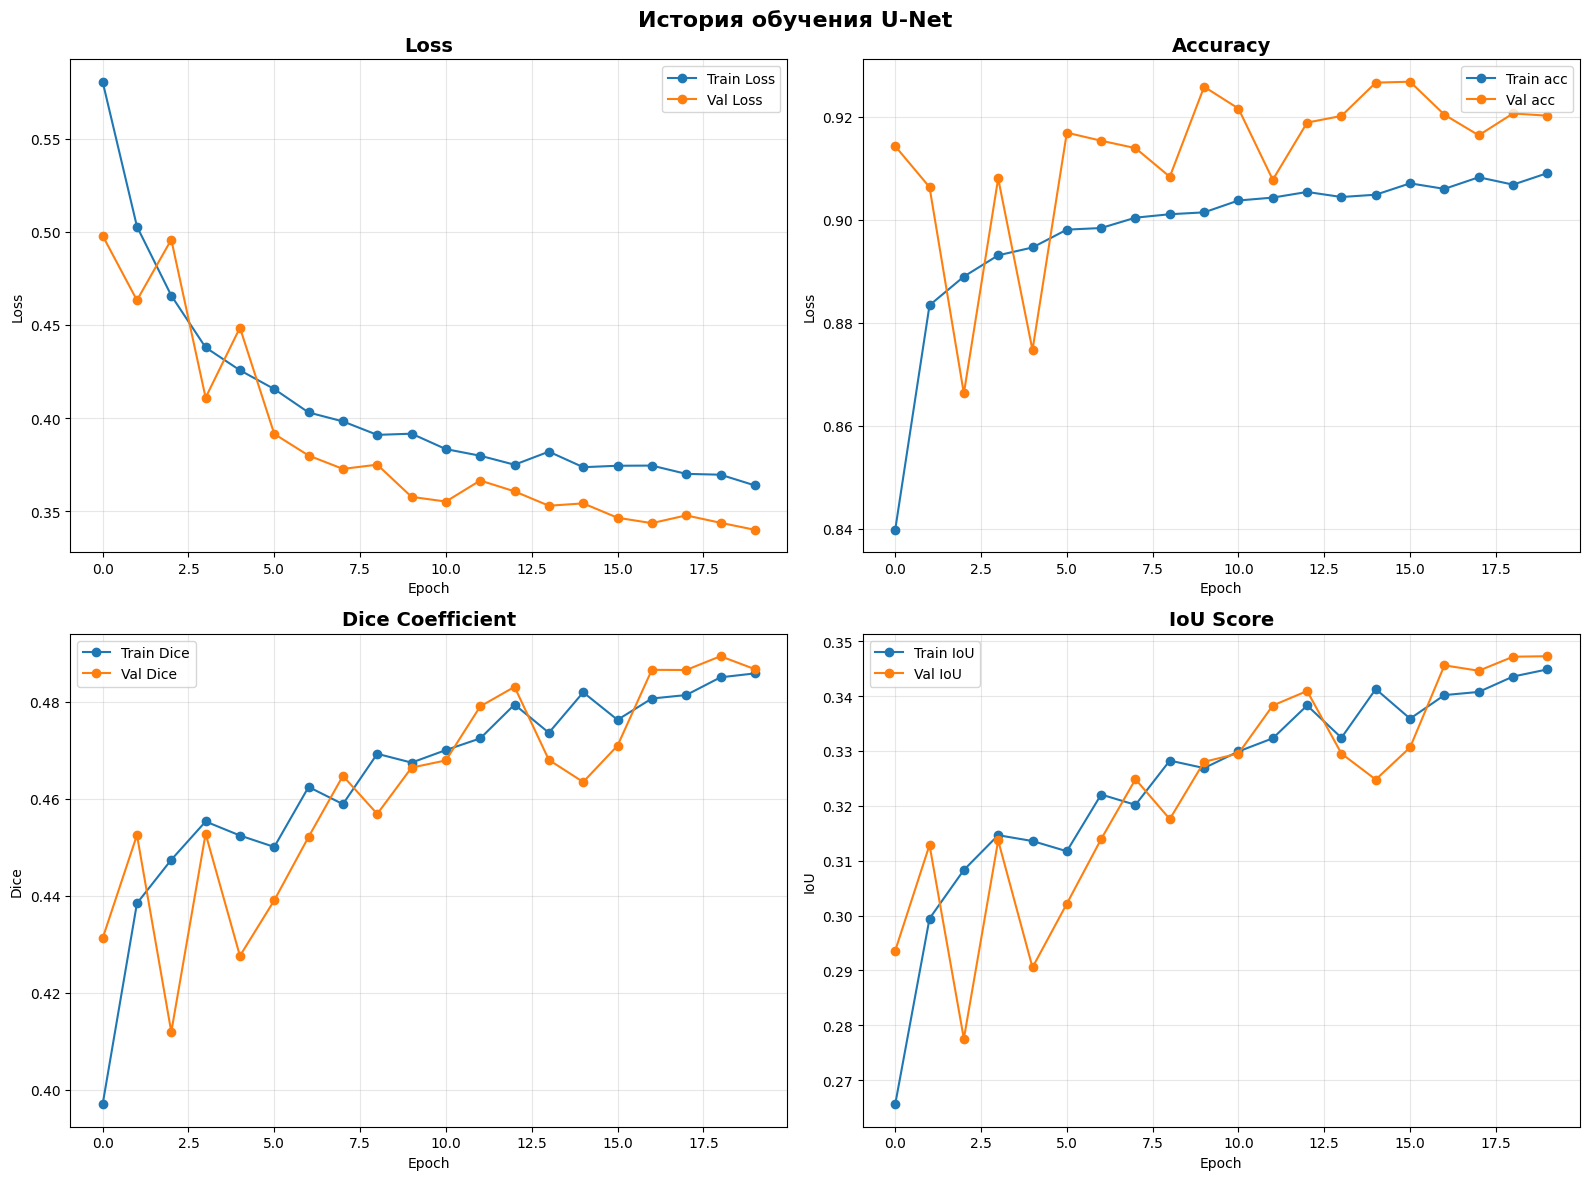

Train Loss: 0.3638
Val Loss: 0.3400
Train Dice: 0.4858
Val Dice: 0.4867
Train IoU: 0.3449
Val IoU: 0.3473
Val Accuracy: 0.9202


In [34]:
plot_training_history(history_resunet_frozen)

Визуализации:

In [35]:
from hw_3.utils import visualize_predictions

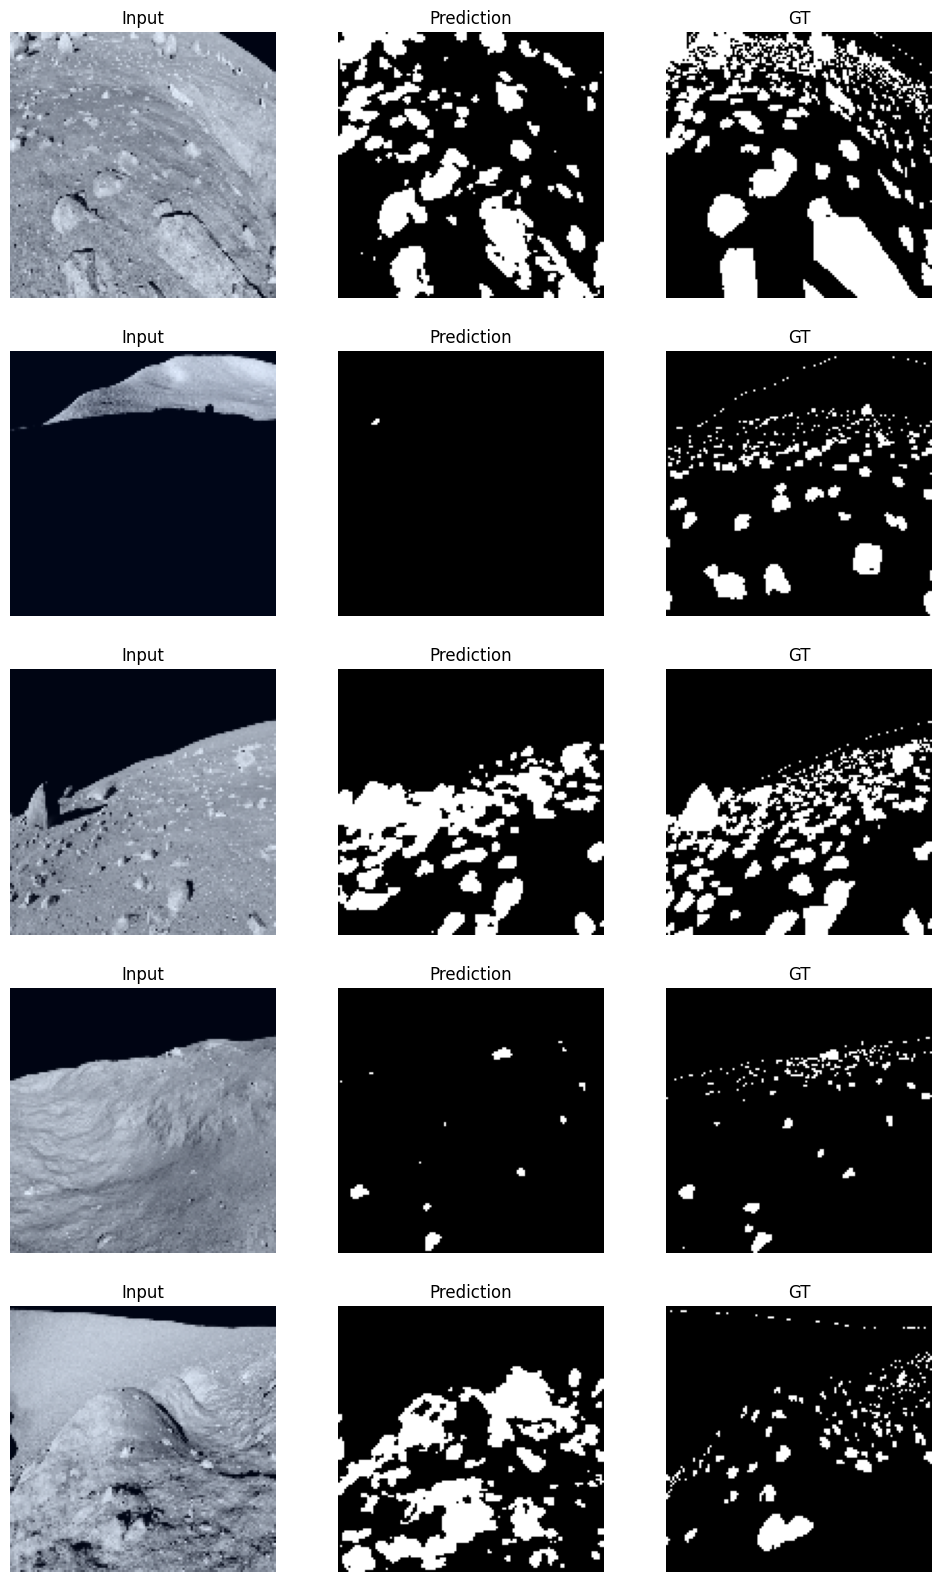

In [36]:
visualize_predictions(model_resunet, moon_val_dataset, device="cuda", n=5)

### Вариант B

Размораживаем веса, и продолжаем обучение

In [37]:
for p in model_resunet.encoder.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(
    model_resunet.parameters(), lr=1e-4
)

history_resunet_ft = train(
    model_resunet,
    moon_train_loader,
    moon_val_loader,
    optimizer,
    criterion,
    device="cuda",
    epochs=10
)


Epoch 1/10 | Train IoU: 0.354, Val IoU: 0.354, Val Dice: 0.497, Val Pixel Acc: 0.922
Epoch 2/10 | Train IoU: 0.357, Val IoU: 0.354, Val Dice: 0.496, Val Pixel Acc: 0.929
Epoch 3/10 | Train IoU: 0.358, Val IoU: 0.347, Val Dice: 0.485, Val Pixel Acc: 0.927
Epoch 4/10 | Train IoU: 0.359, Val IoU: 0.355, Val Dice: 0.495, Val Pixel Acc: 0.927
Epoch 5/10 | Train IoU: 0.360, Val IoU: 0.365, Val Dice: 0.506, Val Pixel Acc: 0.930
Epoch 6/10 | Train IoU: 0.367, Val IoU: 0.364, Val Dice: 0.504, Val Pixel Acc: 0.931
Epoch 7/10 | Train IoU: 0.368, Val IoU: 0.355, Val Dice: 0.494, Val Pixel Acc: 0.930
Epoch 8/10 | Train IoU: 0.368, Val IoU: 0.362, Val Dice: 0.502, Val Pixel Acc: 0.931
Epoch 9/10 | Train IoU: 0.370, Val IoU: 0.338, Val Dice: 0.474, Val Pixel Acc: 0.931
Epoch 10/10 | Train IoU: 0.371, Val IoU: 0.366, Val Dice: 0.507, Val Pixel Acc: 0.929


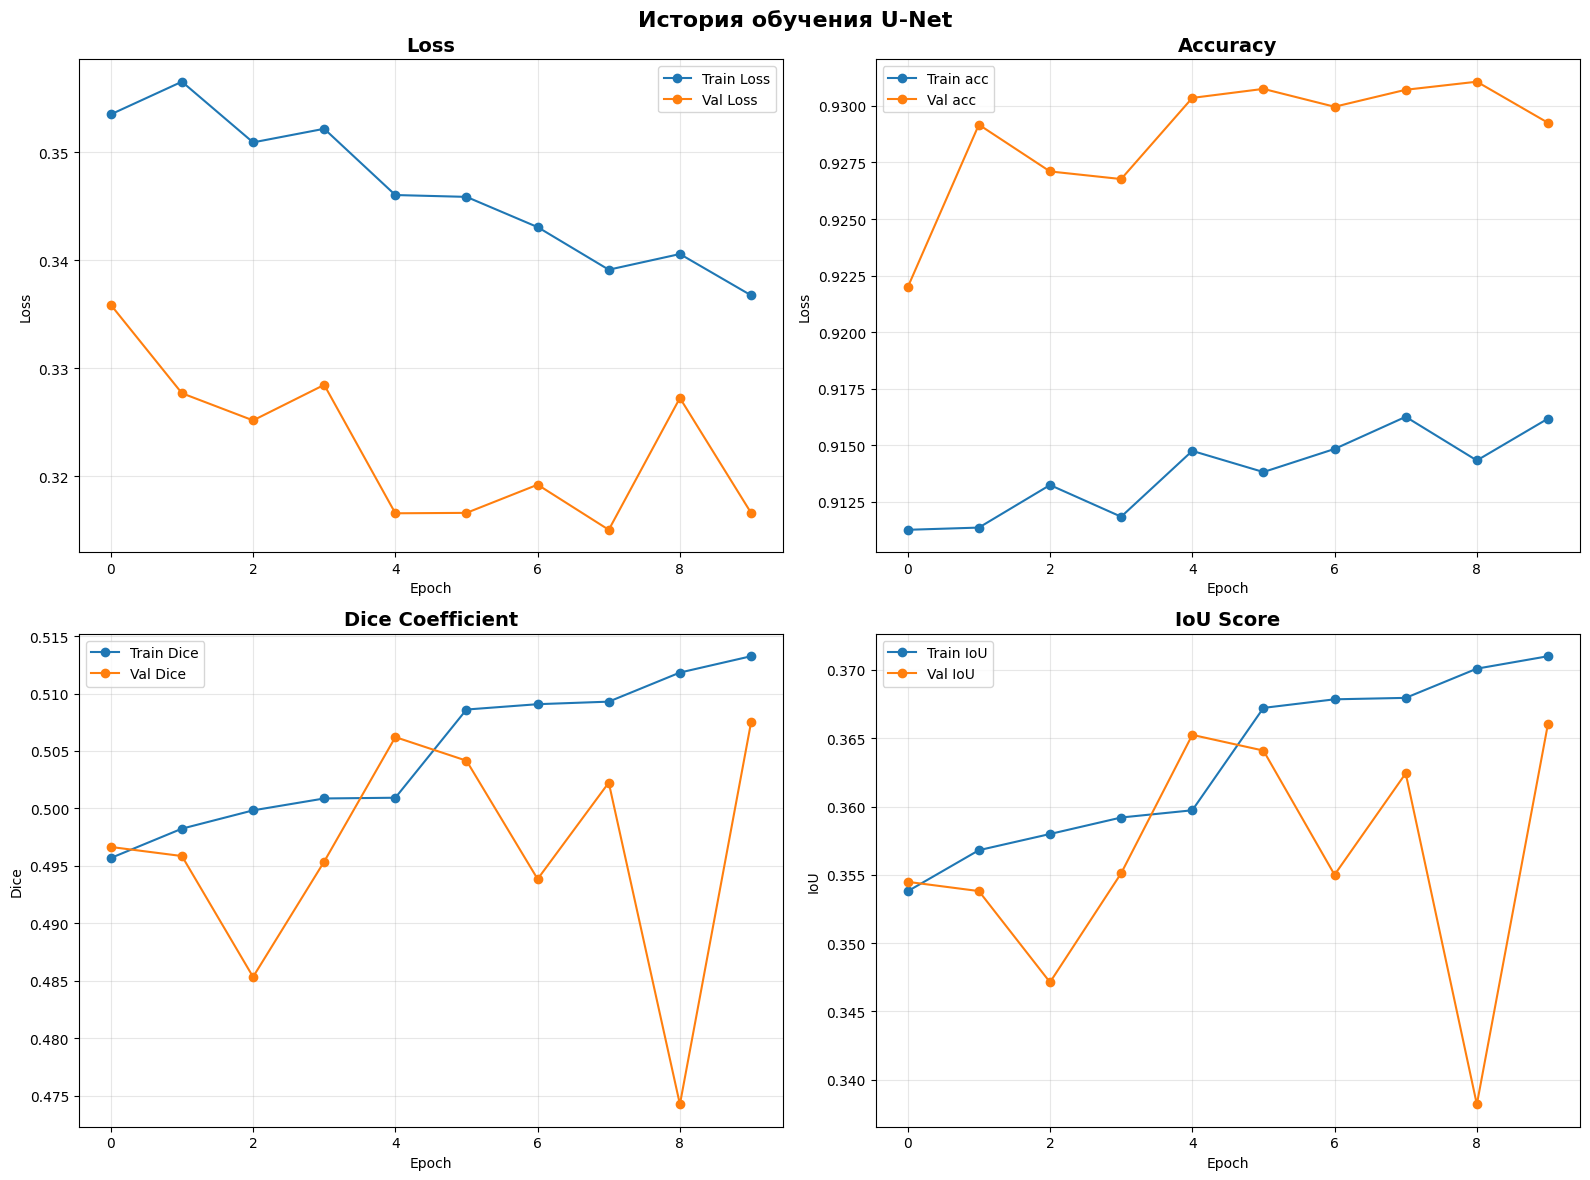

Train Loss: 0.3368
Val Loss: 0.3166
Train Dice: 0.5132
Val Dice: 0.5075
Train IoU: 0.3710
Val IoU: 0.3661
Val Accuracy: 0.9293


In [38]:
plot_training_history(history_resunet_ft)

Визуализации:

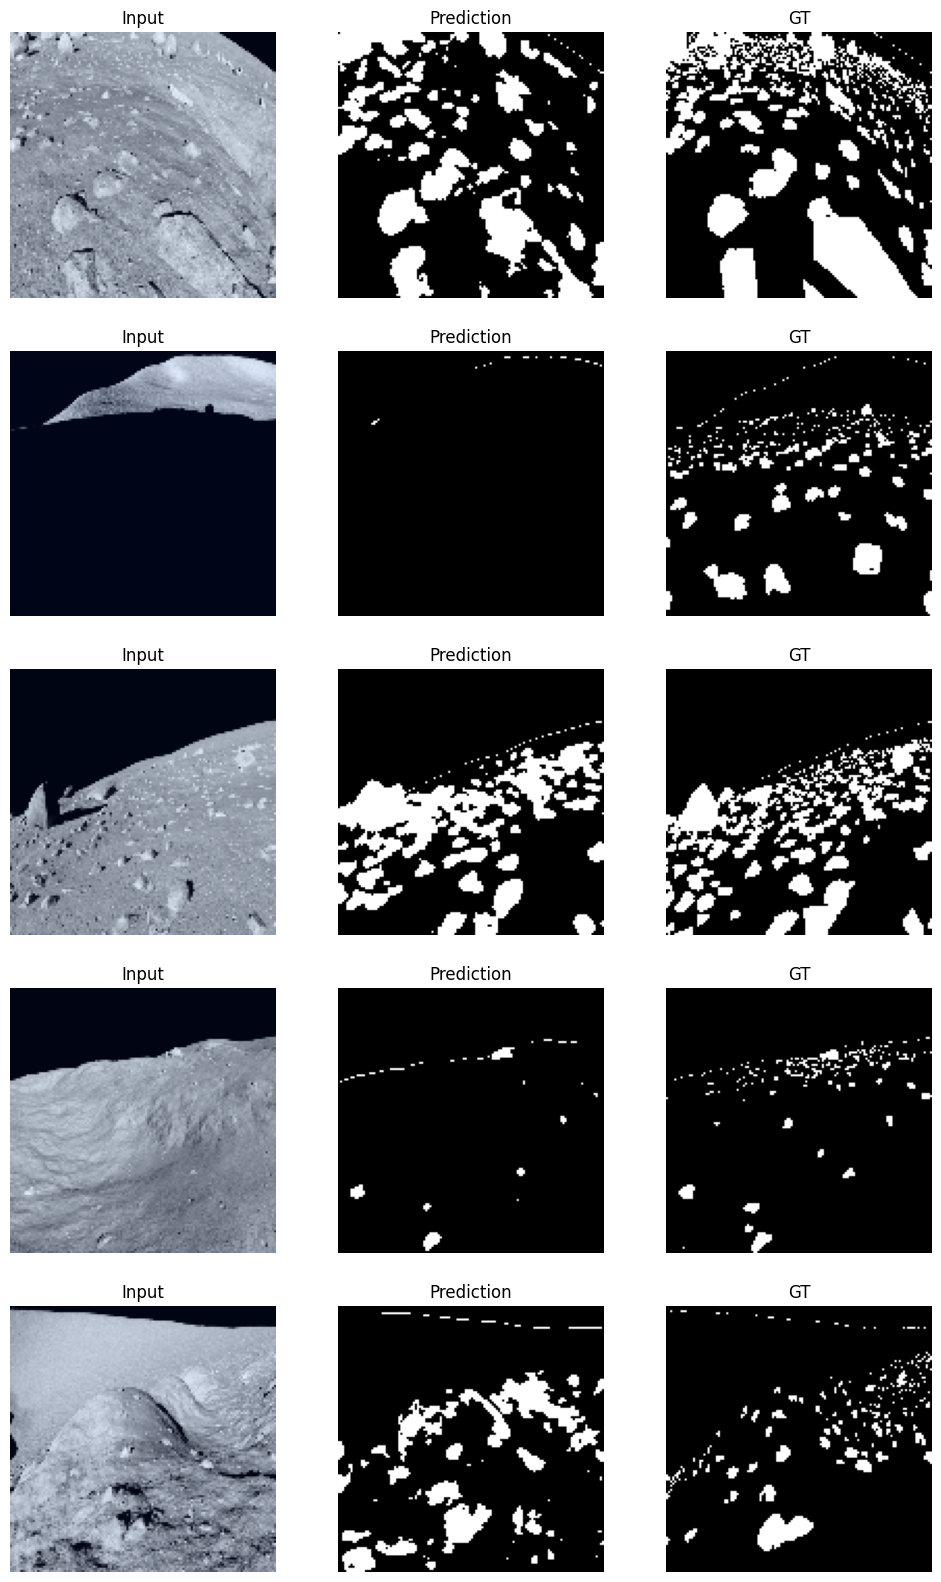

In [39]:
visualize_predictions(model_resunet, moon_val_dataset, device="cuda", n=5)

## Результаты по всем моделям:

|           | Модель       | Encoder  | Trainable Encoder |  IoU   |  Dice  | Pixel Acc |
|-----------| ------------ | -------- | ----------------- | ------ | ------ | --------- |
| Часть 2   | U-Net        | —        | —                 | 0.3861 | 0.5268 |  0.9373   |
| Часть 3.A | ResNet-U-Net | ResNet18 | Yes               | 0.3472 | 0.4893 |  0.9267   |
| Часть 3.B | ResNet-U-Net | ResNet18 | No                | 0.3661 | 0.5074 |  0.9310   |


По результатам эксперементов получилось, что unet без бэкбона из resnet показывает лучшие резульаты, чем две остальные модели. При дообучении с разблокированным энкодером точность выросла относительно обучения только декодера. Скорее всего это связано с тем, что в resnet обучался на другом датасете и точность при его использовании выросла только после разморозки.